# 2022-01-02b Looking closer at the most challenging phenomena to reproduce

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/98c7a73494b4d9d662357a6cea5463daed65f797 (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

Running a bunch of tests below, to try to get a better understanding of the following questions:

* Why does `oVAoBE*` not exhibit early pedestrian crossing? (I believe I know)
* Why does `oVAoBE*oAI` exhibit prio assertion and (such substantial) short stopping? (I believe I know)
    * Related: Vanilla `oVA` does also seemingly brake more than needed in the short stopping scenario - why?
* Why does `oVAaoBE*oAI` not exhibit prio assertion and short stopping? (I believe I know)
* Why does `oVAaoVAloBE*oAI` not exhibit prio assertion and short stopping? (I am not sure I know)

(addressing the above questions in a different order below)

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
    sys.path.append(parent_path + '/SCPaper')
print(sys.path)

import sc_fitting

def run(i_variation = 0, snapshots=(None, None), detailed_snapshots=False, plot_veh_stop_dec=False, end_time=12):
    scenario.end_time = end_time
    sim = sc_fitting.construct_model_and_simulate_scenario(model, params_dict, scenario,
                                                           i_variation=i_variation, 
                                                           apply_stop_criteria=False,
                                                           snapshots=snapshots,
                                                           detailed_snapshots=detailed_snapshots,
                                                           report_time=True)
    sim.do_plots(kinem_states=True, beh_probs=('oBE' in model), beh_activs=False, 
                  action_val_ests=False, surplus_action_vals=False, looming=False,
                  veh_stop_dec=plot_veh_stop_dec)
    metrics = sc_fitting.get_metrics_for_scenario(scenario, sim, verbose=True)
    if plot_veh_stop_dec:
        veh_agent = sim.agents[sc_fitting.i_VEH_AGENT]
        print(f'Final vehicle distance to conflict space: {veh_agent.signed_CP_dists[-1] - veh_agent.coll_dist} m')


['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework', 'C:\\GITHUB\\COMMOTIONSFramework/SCPaper']


## Short-stopping

### Why does vanilla `oVA` exhibit what seems like short stopping?

Below we can see that at t = 0.3 s, even though the car is already expecting to be apply more than the deceleration needed to stop before the conflict space (including safety margin $D_s$), it still sees benefit in decelerating further, since the anticipated constant deceleration during the rest of the approach looks nicer with a lower magnitude. So (at least part of) the reason why this model exhibits more deceleration than needed early in the yielding is that the anticipated own behaviour in the "affordance-based value function" approach does not exactly correspond to the actual future behaviour of the agent (because the agent doesn't apply constant deceleration in the future).

It should be noted, however, that the car actually stops at about $D_s$ in the end, so in that sense it could be argued that the model isn't actually short-stopping.

C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


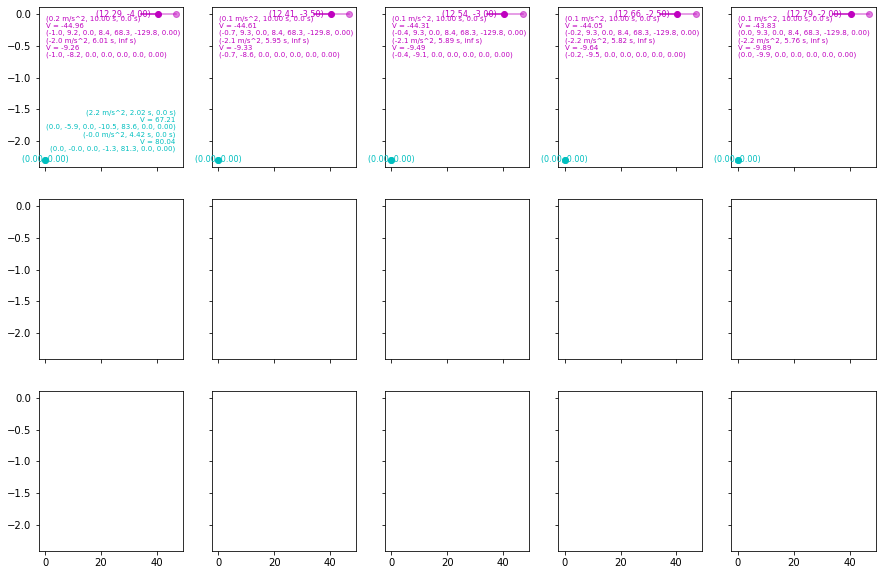

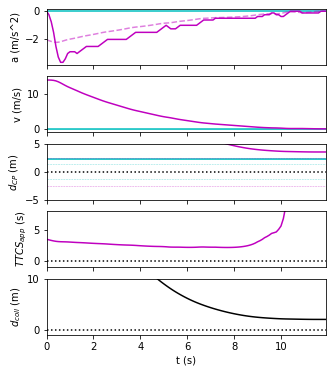

Metric VehShortStop_veh_av_surpl_dec = 1.008718332535814
Final vehicle distance to conflict space: 1.0100000000000433 m


In [2]:
model = 'oVA'
params_dict = {'T_delta': 60}
scenario = sc_fitting.ONE_AG_SCENARIOS['VehShortStop']
run(snapshots=(None, (0.3,)), plot_veh_stop_dec=True)

### Why does `oVAoBE*oAI` exhibit (such substantial) short stopping?

Running the `oVAoBEvoAI` model that achieved all four main criteria in the 2021-12-10 fits, we see that it estimates a higher value for the pedestrian for passing first the more the ego vehicle decelerates (from 80.75 to 81.46 zero to full deceleration), with only a marginal decrease in the value for the ego vehicle of passing second (from 74.03 to 73.96). Note that at the snapshot time of t = 0.5 s, the vehicle deceleration is already at about twice the deceleration needed to stop before the conflict space (with safety distance $D_s$). 

And note that here the car actually comes to a clearly early stop.

Also note in the second snapshot below, at t = 4.5 s, that the added peak of deceleration at this time seems to be due to the car now judging that further deceleration will reduce the value of the passing-second behaviour for the pedestrian (this was not the case earlier in the simulation - in the t = 0.5 s snapshot below the largest effects of car deceleration on the pedestrian's behaviour values is on the passing-first values). The reason for this effect at this point is that the larger decelerations make the anticipated first-passing of the car happens further into the future, such that the pedestrian will have to wait longer in order to pass second.

So overall the answer to the question in the heading above is that thanks to not taking ego accelerations into account when valuing behaviours of the other agent, `oVAoBE*oAI` sees further increased probability of pedestrian crossing first even when at large yielding decelerations - hence the substantial short-stopping. 

C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


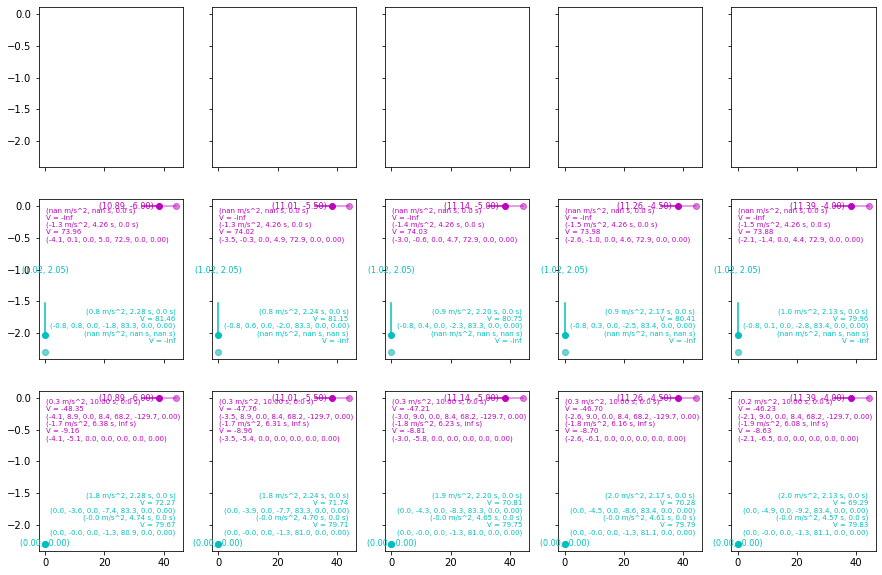

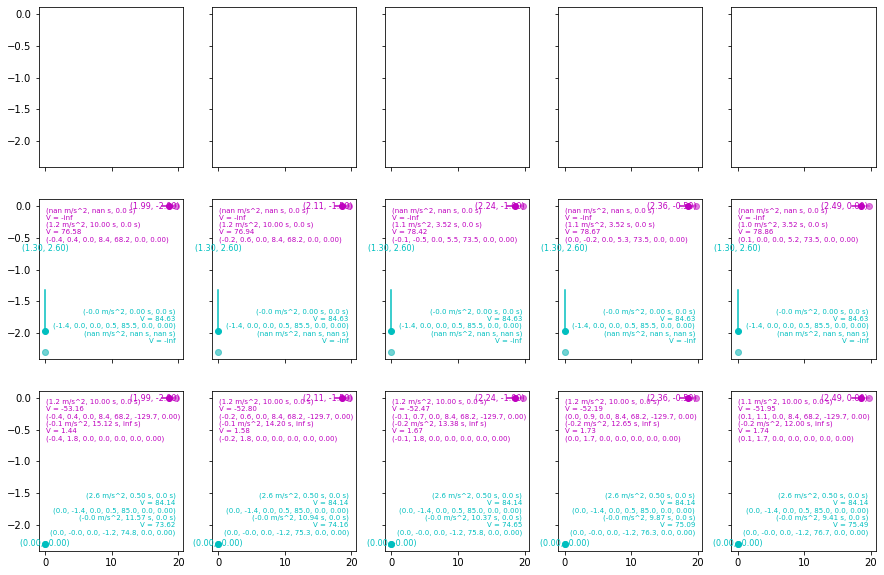

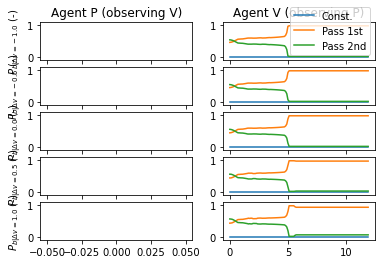

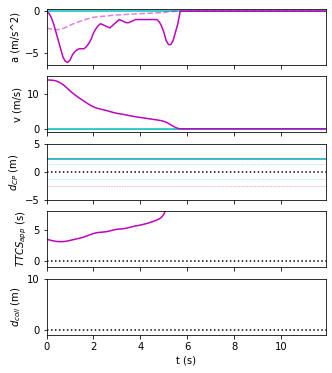

Metric VehShortStop_veh_av_surpl_dec = 2.7547112106093246
Final vehicle distance to conflict space: 15.41083333333334 m


In [3]:
model = 'oVAoBEvoAI'
params_dict = {'T_delta': 59.95, 'beta_V': 18.98}
scenario = sc_fitting.ONE_AG_SCENARIOS['VehShortStop']
run(snapshots=(None, (0.5, 4.5)), plot_veh_stop_dec=True)

### Why does `oVAaoBE*oAI` not exhibit short stopping? 

Testing first the same model parameterisation as for `oVAoBEvoAI` above, and then the parameterisation for `oVAaoVAloBEvoAI` (except $\dot{\theta}_1$) that was identified as showing short-stopping in the 2021-10-29 results (with the quite permissive criterion used then). The results for both are qualitatively similar: 
* There is a first phase (exemplified by snapshots at t = 1 s) where the car quickly settles on pedestrian crossing first being the most probable pedestrian behaviour, with no further increase in probability of that behaviour with further increased car deceleration. This is because it looks to the car like the pedestrian should be able to cross first comfortably given the car's current yielding deceleration. This is what I was expecting.
* A second phase (exemplified by snapshots at t = 4 s) where the car instead thinks pedestrian passing second is the most likely behaviour. This seems to be due to the assumption in the model that the behaviour accelerations for the pedestrian don't take the car accelerations into account. When presented like this, this combination of assumptions (car accelerations are not considered when generating pedestrian behaviour hypotheses, but they are considered when estimating the value of those hypothetical behaviours for the pedestrian) seems a bit awkward...
    * I can think of two possible ways to go here: Either (1) modify so that the other-behaviour hypothesis generation does consider ego-acceleration for `oVAa` models (if so I should first look back at the notes from when I first introduced the current, acceleration-free assumption), or (2) look again at the possibility of not considering accelerations at all in neither the other-behaviour hypothesis generation nor in the valuation of those hypotheses for the other, thus leaving `oVAa` to mean only that the ego agent considers accelerations of the other agent when doing valuation of own actions. Again there are old notes to look at here - I know I looked briefly at this possibility once in the past but got some weird results - can't quite remember what or why now.
* A transition between the first two phases, where for especially the first parameterisation below there seems to be a tendency to exaggerate deceleration, presumably because the model sees that increased decelerations reduce the pedestrian-pass-first probabilities of the pedestrian - so during this transition there is seemingly a similar type of short-stopping tendency in the model as for `oVAoBE*oAI`.
* A third phase, close to zero speed, when again the model deems the pedestrian should be able to easily pass in front of the car.

Overall, the answer to the question in the heading is that the `oVAaoBE*oAI` car does not generally see any benefit in increasing deceleration beyond what is needed to stop at the pedestrian, since the car assumes the pedestrian sees this yielding acceleration and factors it into its valuation of the pedestrian behaviours. 

C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


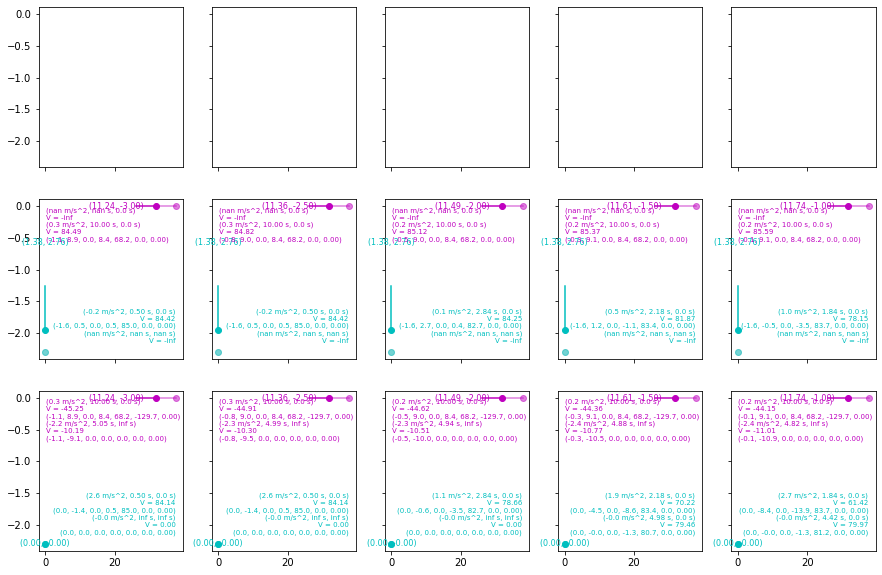

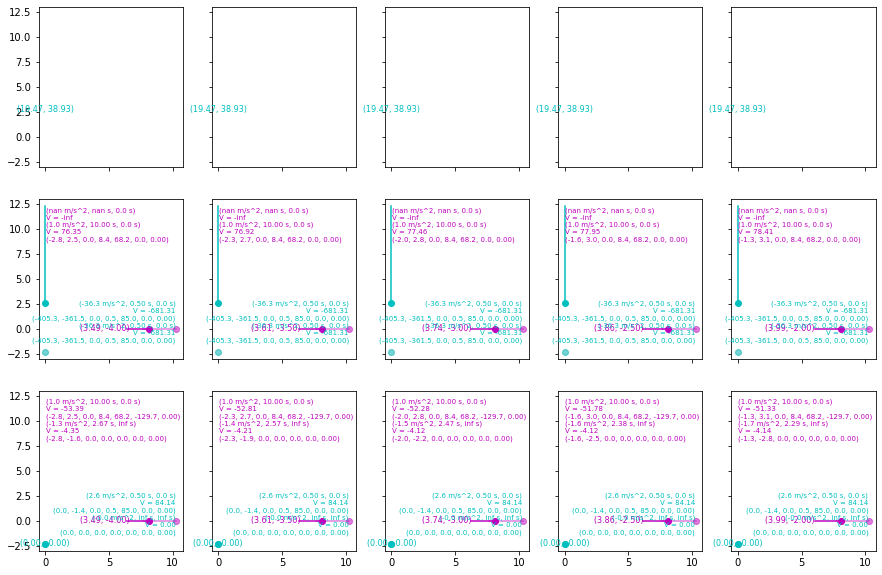

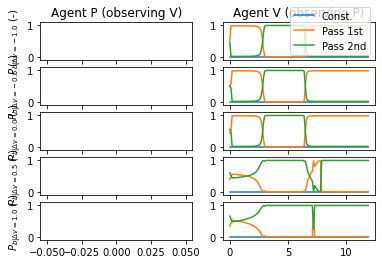

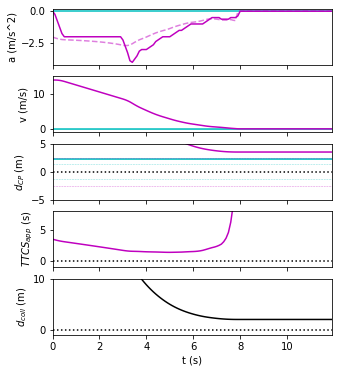

Metric VehShortStop_veh_av_surpl_dec = -0.30399659438526394
Final vehicle distance to conflict space: 1.0013888888887896 m





C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


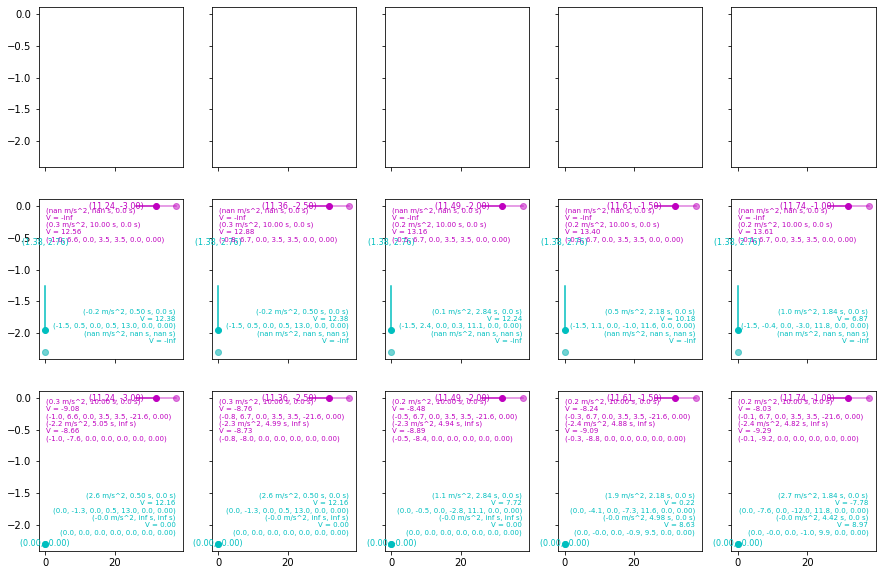

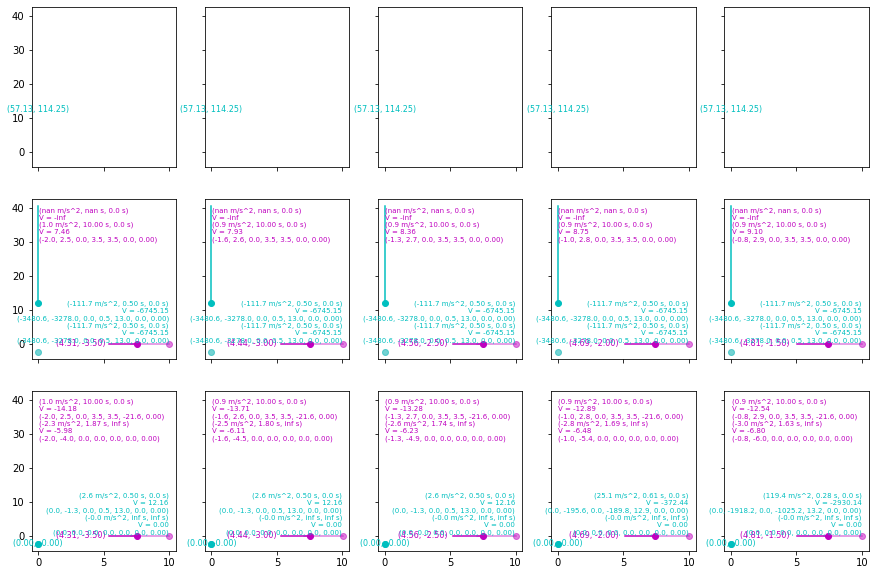

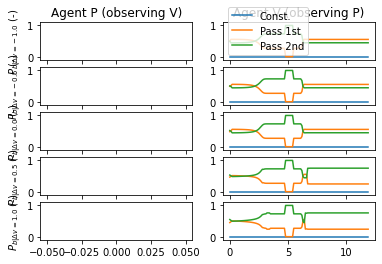

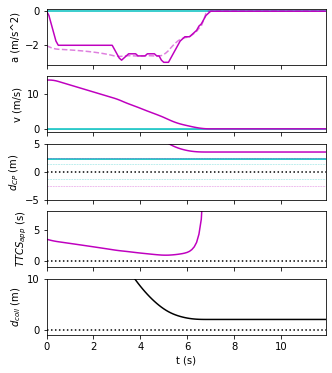

Metric VehShortStop_veh_av_surpl_dec = -0.30399659438526394
Final vehicle distance to conflict space: 1.0027777777777023 m


In [4]:
model = 'oVAaoBEvoAI'
scenario = sc_fitting.ONE_AG_SCENARIOS['VehShortStop']

params_dict = {'T_delta': 59.95, 'beta_V': 18.98}
run(snapshots=(None, (1, 4)), plot_veh_stop_dec=True)
print('\n\n')
params_dict = {'T_delta': 10.0, 'beta_V': 1.0}
run(snapshots=(None, (1, 4)), plot_veh_stop_dec=True)

### Why does `oVAaoVAloBE*oAI` not exhibit short stopping?

Now trying the full `oVAaoVAloBEvoAI` that was identified as showing short-stopping in the 2021-10-29 results (with the quite permissive criterion used then).

Again some distinct phases are discernible, very similar to what I saw just above for `oVAaoBEvoAI`:
* A first phase, where pedestrian passing first seems most probable to the car, again with no clear increase in passing-first probability from further deceleration. Here, one could have assumed that the `oVAl` assumption should create such added probability, but it doesn't, and I think this may be (partly?) caused by the implementation imperfection that I have noted earlier, that looming values are only calculated for the anticipated future up until the point when the agent has regained free speed, such that early on in this simulation, when the pedestrian can pass first by just accelerating to free speed, the looming valuation may be cut short. I don't know how big this effect is though...
* A second phase, where, again just like for `oVAaoBEvoAI` above, the pass-first pedestrian behaviour looks very low-value, due to that behaviour being calculated without taking car accelerations into account.

Also some further phases (which were also visible in the second parameterisation of `oVAaoBEvoAI` above), but I am not looking more closely at them now.

Further below I am also simulating the same model, but with a further reduced $\dot{\theta}_1$ (close to $\dot{\theta}_0$ = 0.001 rad/s), i.e., making the more sensitive to looming, and with an increased $\beta_V$, i.e., making the model more sensitive to value differences in its `oBEv` behaviour probability estimates. Now the model does show what seems to be a clear short-stopping tendency just at the start, because of the looming seen by the pedestrian in the short period before the pedestrian reaches free speed. After a little while, however, that looming is beginning to look so scary that passing first is judged as equally as unsavoury for the pedestrian as passing second. And then the other mechanisms already discussed above kick in, getting into a phase where pedestrian first-passing is looking like a lost cause to the car, because the pedestrian first-passing hypothesis is calculated based without taking the car acceleration into account.

C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


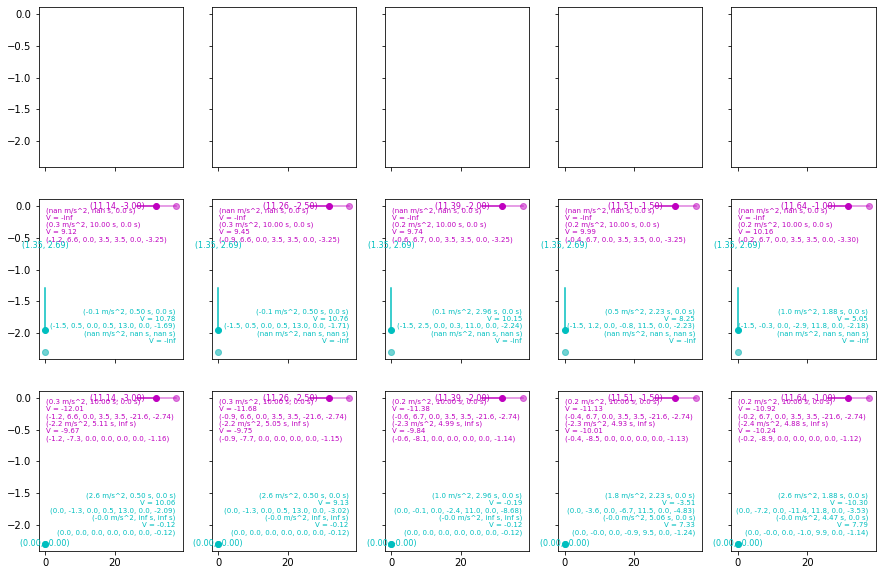

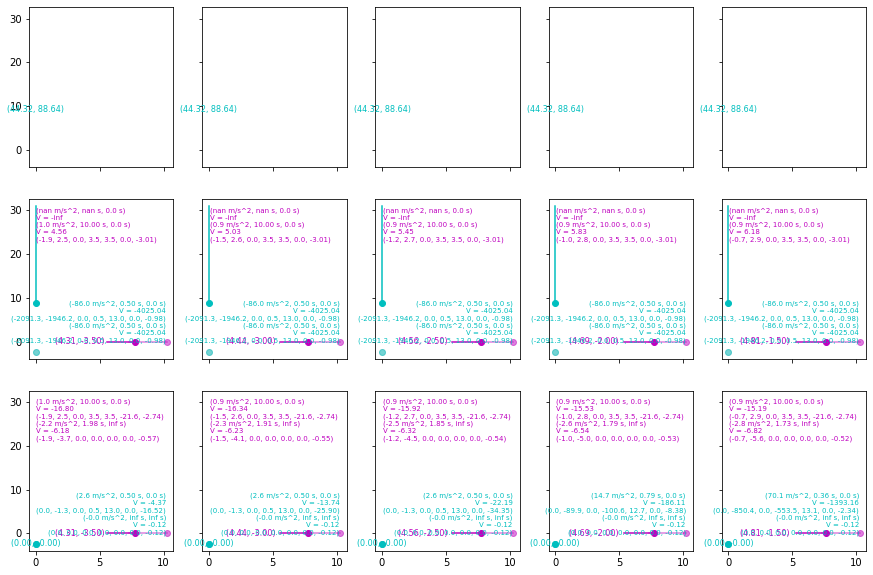

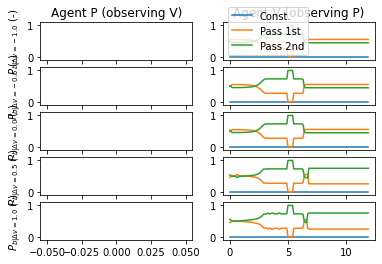

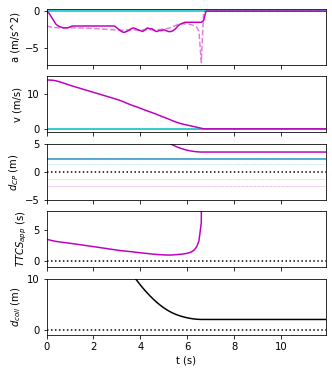

Metric VehShortStop_veh_av_surpl_dec = -0.19744641918446879
Final vehicle distance to conflict space: 1.0005555555554908 m


In [5]:
model = 'oVAaoVAloBEvoAI'
scenario = sc_fitting.ONE_AG_SCENARIOS['VehShortStop']
params_dict = {'T_delta': 10.0, 'thetaDot_1': 0.005, 'beta_V': 1.0}
run(snapshots=(None, (1, 4)), plot_veh_stop_dec=True)

C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


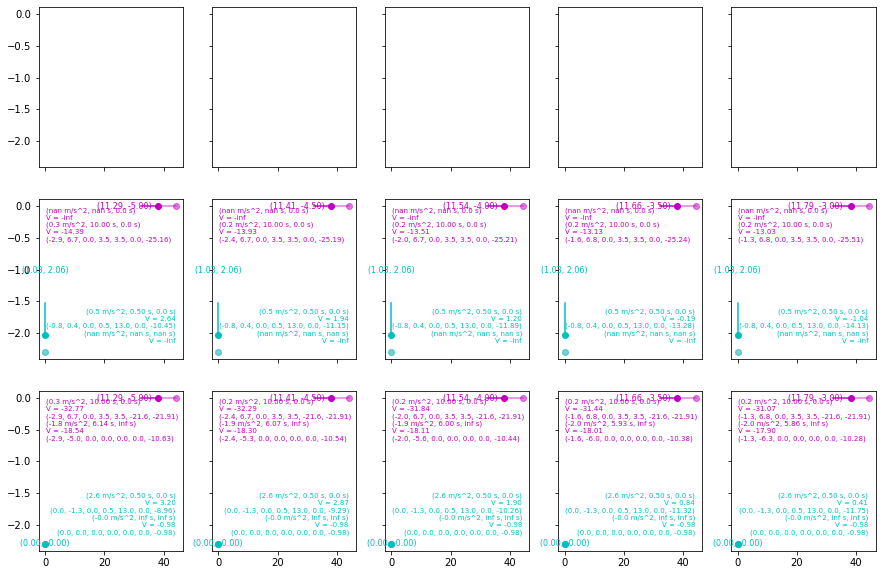

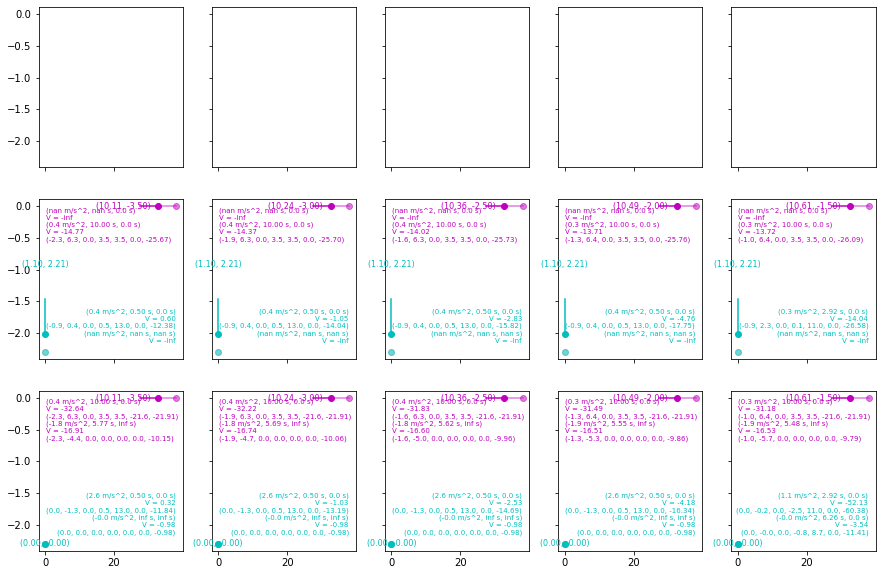

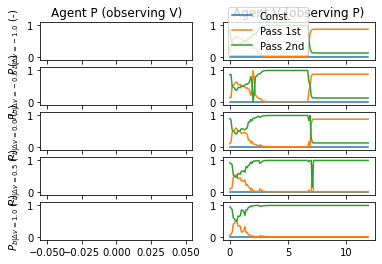

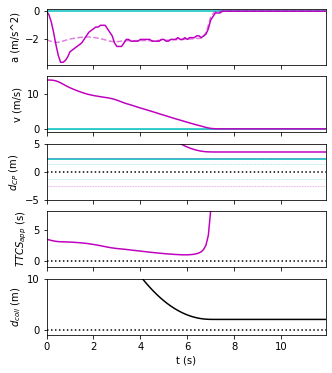

Metric VehShortStop_veh_av_surpl_dec = 0.5493240386231507
Final vehicle distance to conflict space: 1.008333333333367 m


In [6]:
params_dict = {'T_delta': 10.0, 'thetaDot_1': 0.0015, 'beta_V': 10.0}
run(snapshots=(None, (0.5, 1)), plot_veh_stop_dec=True)

### Summary

The only models that really exhibit short-stopping in the sense of stopping more than a distance $D_s$ before the conflict area is the `oVAoBE*oAI`.

The `oVAaoBE*oAI` models do not in general exhibit short-stopping in this sense, for quite natural reasons which follow from the model assumptions. There are some hints of short-stopping behaviour though, due to the arguably somewhat awkward assumption in this model that the car's hypotheses about the pedestrian's behaviours disregard the car accelerations.

The `oVAaoVAloBE*oAI` models seem hampered by the current implementation imperfection in how anticipated looming values are only calculated up until the time an agent has regained its free speed, but again the arguably awkward assumption regarding how behaviour hypotheses are generated in the `oVAao*oBE*` models (it is arguably not awkward for the `oVAo*oBE*` models) seems to be playing a role, but in this case it seemingly counteracts short-stopping tendencies in the model.

Possible actions which may make the `oVA[oVAl]oBE*oAI` models exhibit short-stopping:
* Resolve the assumption awkwardness, for example in one of the two ways outlined under "Why does `oVAaoBE*oAI` not exhibit short stopping?" above:
    * Consider ego-acceleration also in other-behaviour hypothesis generation, not only in valuation of other-behaviours. If so, `oVAl` should remain needed to see short-stopping, and it seems likely that I would also need to address the looming value calculation imperfection to make this work. 
        * See the diary notes from 2021-08-31 and 2021-09-01 for an explanation for why it is currently implemented as it is. My interpretation is that to take this route, it is not really a matter of considering a constant ego-acceleration from current time, but rather to consider the entire currently decided-on ego-acceleration from current time - otherwise we get into the problems mentioned in those diary notes, where a current acceleration for a pedestrian who is in the process of changing speed gets extrapolated indefinitely. A poor man's version of what I am saying here would be to consider constant ego-acceleration from current time for acceleration-controlling agents, but not for speed-controlling agents.
    * Stop considering ego-acceleration in valuation of other-behaviours, also in `oVAa` models. This could possibly allow for short-stopping even without the `oVAl` assumption.
        * I was reasoning about this possibility in the 2021-11-27 diary notes, and then in the 2021-11-29 commit I noted in the SCPaper README that doing this "seems to create some unintended knock-on effects, so leaving as is at least for now". I don't remember the details of the tests I did back then, though, so this would need to be reconstructed.
* Just address the `oVAl` imperfection, and not the arguably awkward combination of assumptions. However, based on the above, I think this is not likely to succeed.

## Prio assertion

### Why does `oVAoBE*oAI` exhibit prio assertion?

Running the same `oVAoBEvoAI` model parameterisation as above, and from the simulations below it is clear that the answer here is similar to the answer for short stopping above: For some scenario kinematics (here, when the car is sufficiently far away from the conflict space that it doesn't seem obvious to it that the pedestrian will wait and pass in second) the car estimates large probabilities of pedestrian second-passing for higher car accelerations, and the value for the car of all actions is higher when the pedestrian passes in second.

Scenario variation #1/3:


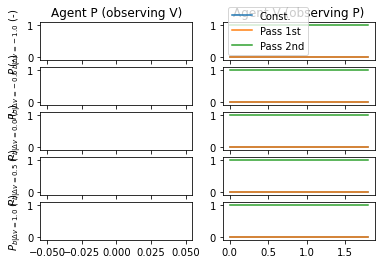

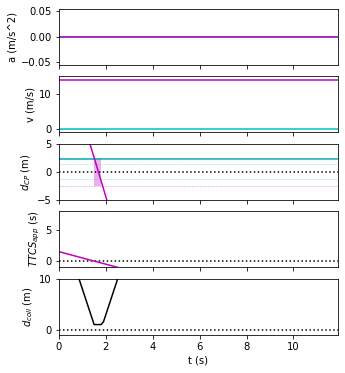

Metric VehPrioAssert_veh_av_speed = 13.88888888888889
Scenario variation #2/3:


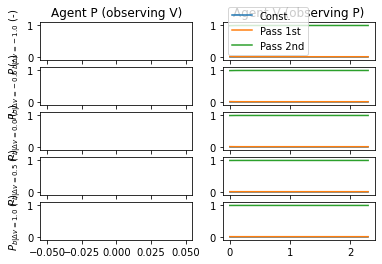

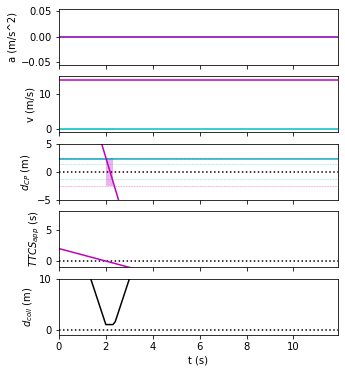

Metric VehPrioAssert_veh_av_speed = 13.88888888888889
Scenario variation #3/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


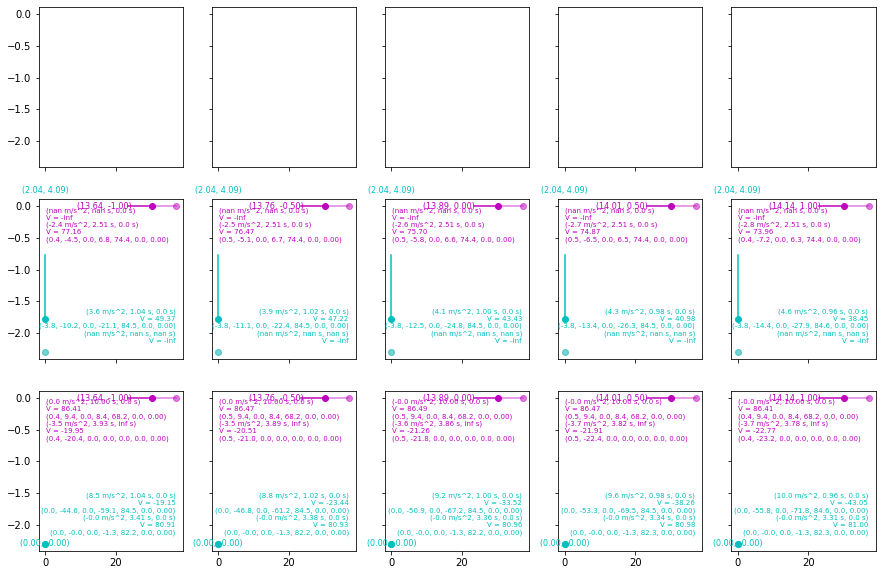

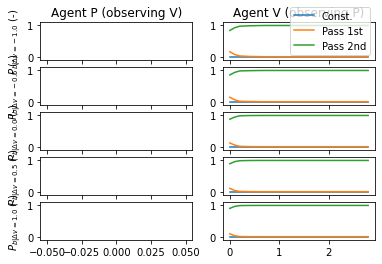

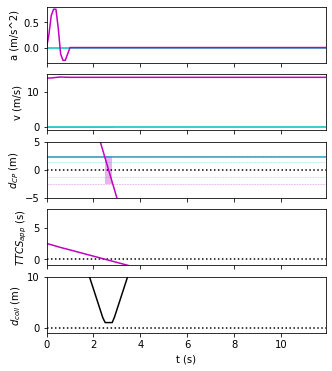

Metric VehPrioAssert_veh_av_speed = 14.050427350427352


In [11]:
model = 'oVAoBEvoAI'
params_dict = {'T_delta': 59.95, 'beta_V': 18.98}
scenario = sc_fitting.ONE_AG_SCENARIOS['VehPrioAssert']
for i_variation in range(scenario.n_variations):
    print(f'Scenario variation #{i_variation+1}/{scenario.n_variations}:')
    if i_variation == 2:
        snapshots = (None, (0,))
    else:
        snapshots = (None, None)
    run(i_variation=i_variation, snapshots=snapshots)

### Why does `oVAaoBE*oAI` not exhibit prio assertion?

Again running the same to `oVAaoBEvoAI` model parameterisations as for the short-stopping tests above. From the simulations below it is clear that I have not (at least not recently) been quite clear about why the `oVAaoBE*oAI` models don't exhibit prio assertion. I thought it was for a (more) similar reason as for why these models don't exhibit short-stopping but it is subtly different, in that here the car clearly estimates that the probability of pedestrian second-passing would increase if the car accelerated, but what is happening instead is that the car doesn't see any benefit from this probability increase, because regardless of whether the pedestrian passes first or second, it is by definition in the `oVAaoBE*` models doing so in a way such that the car doesn't have to change its speed to avoid collision.

Model parameterisation: {'T_delta': 59.95, 'beta_V': 18.98}

	Scenario variation #1/3:


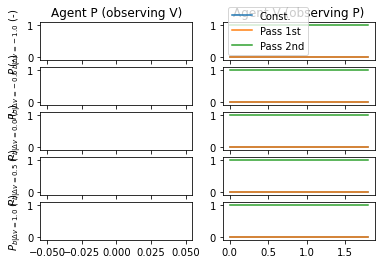

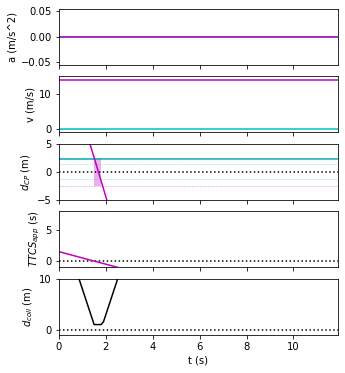

Metric VehPrioAssert_veh_av_speed = 13.88888888888889

	Scenario variation #2/3:


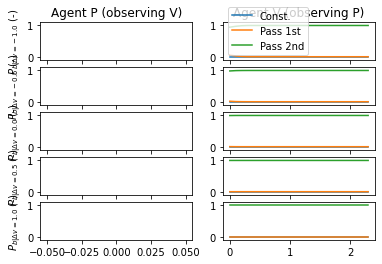

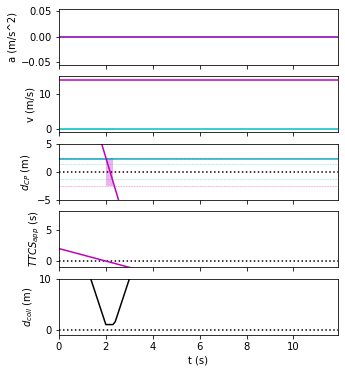

Metric VehPrioAssert_veh_av_speed = 13.88888888888889

	Scenario variation #3/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:

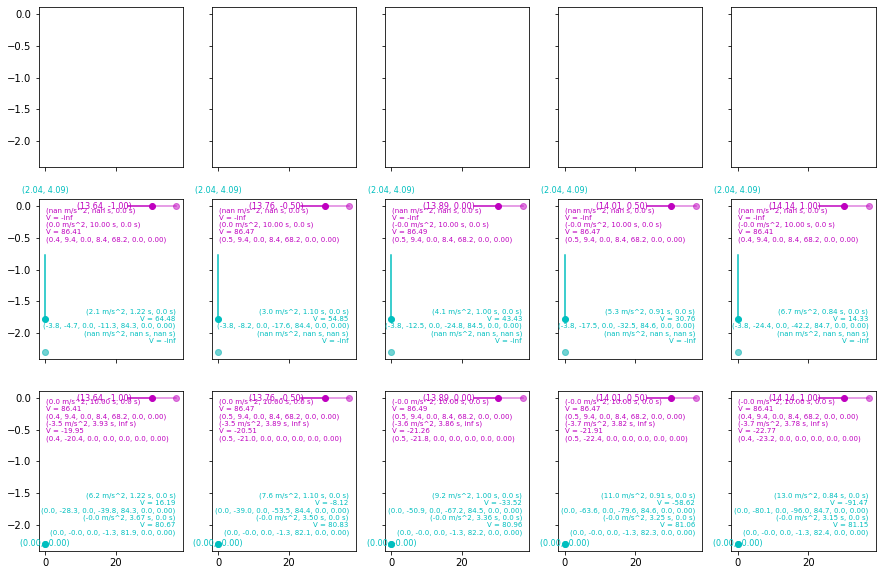

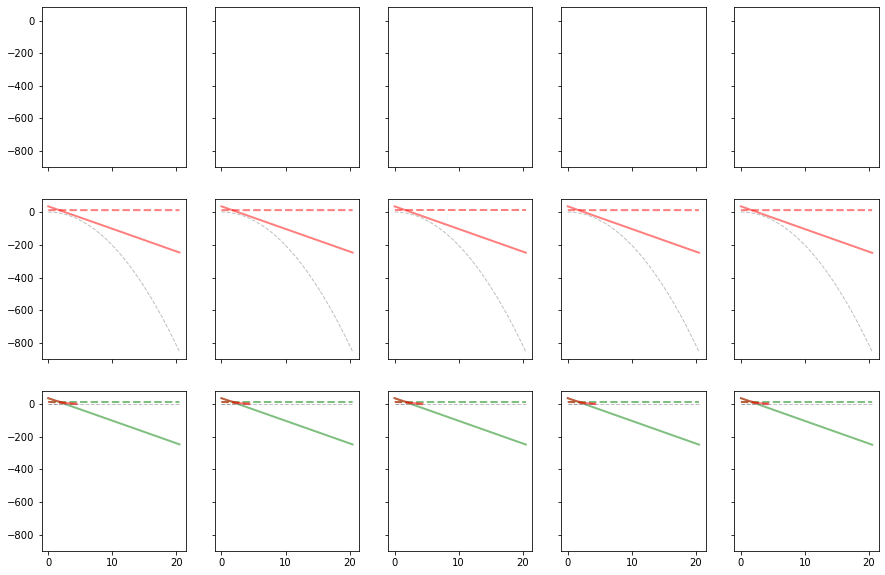

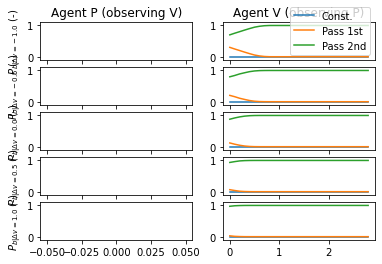

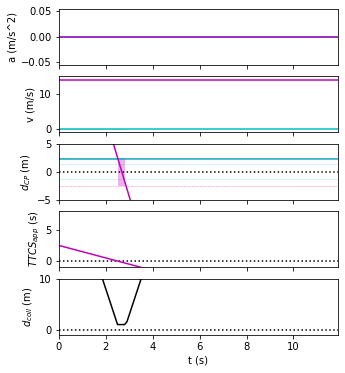

Metric VehPrioAssert_veh_av_speed = 13.888888888888888

Model parameterisation: {'T_delta': 10.0, 'beta_V': 1.0}

	Scenario variation #1/3:


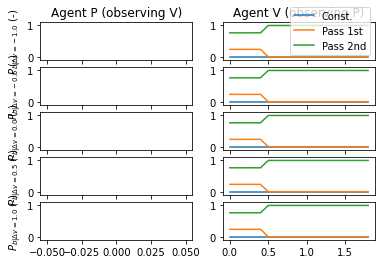

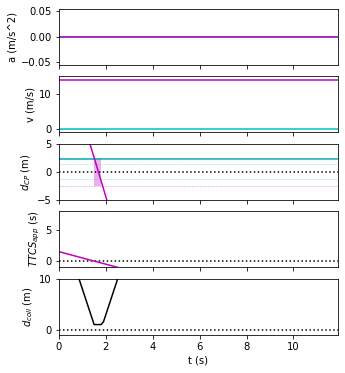

Metric VehPrioAssert_veh_av_speed = 13.88888888888889

	Scenario variation #2/3:


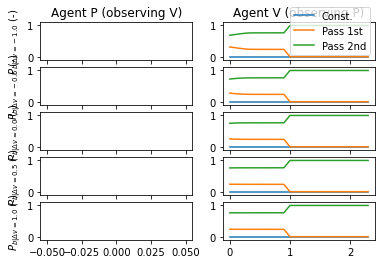

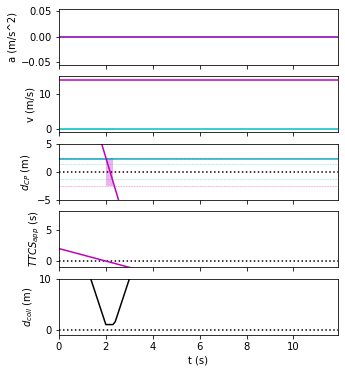

Metric VehPrioAssert_veh_av_speed = 13.88888888888889

	Scenario variation #3/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:

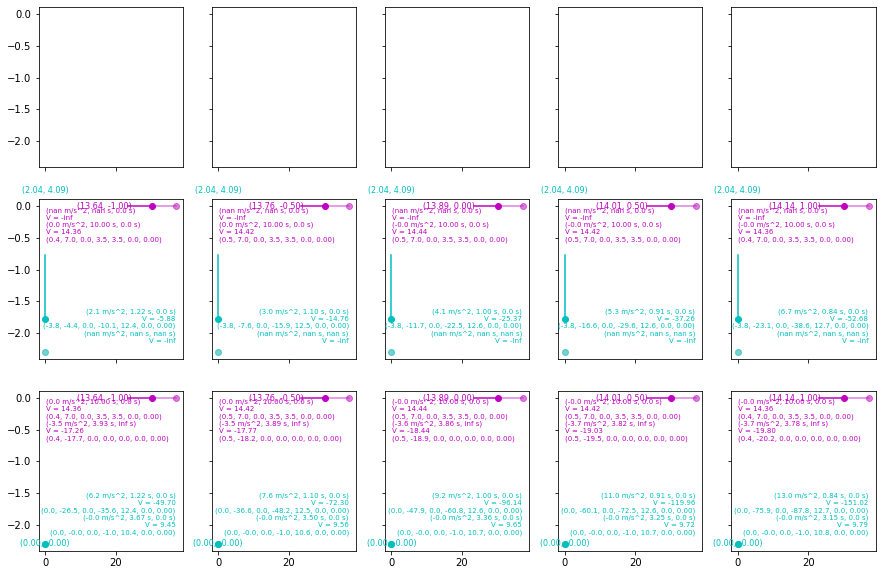

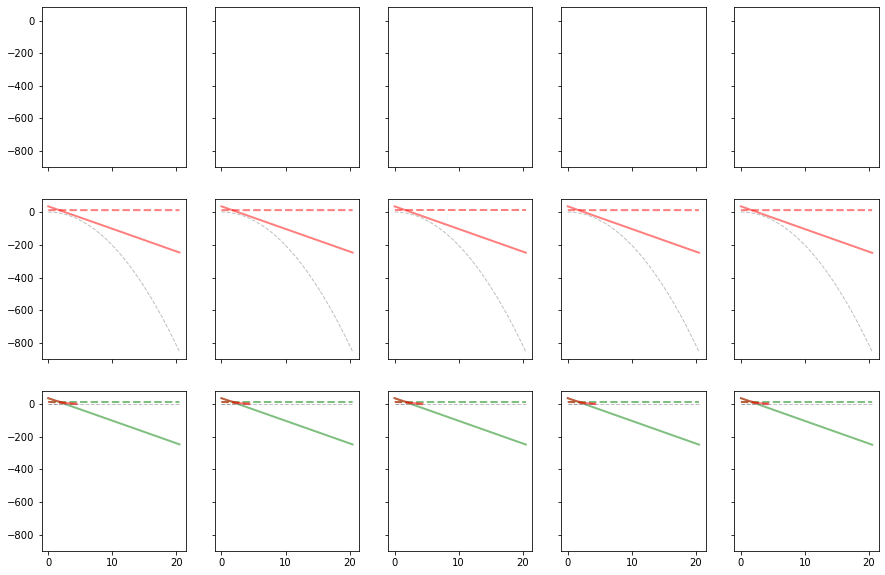

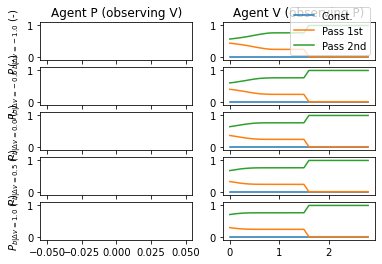

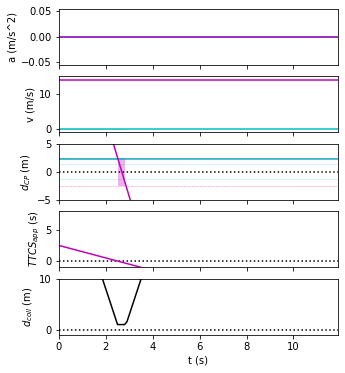

Metric VehPrioAssert_veh_av_speed = 13.888888888888888



In [16]:
model = 'oVAaoBEvoAI'
scenario = sc_fitting.ONE_AG_SCENARIOS['VehPrioAssert']

params_dicts = ({'T_delta': 59.95, 'beta_V': 18.98}, {'T_delta': 10.0, 'beta_V': 1.0})

for params_dict in params_dicts:
    print(f'Model parameterisation: {params_dict}')
    for i_variation in range(scenario.n_variations):
        print(f'\n\tScenario variation #{i_variation+1}/{scenario.n_variations}:')
        if i_variation == 2:
            snapshots = (None, (0,))
        else:
            snapshots = (None, None)
        run(i_variation=i_variation, snapshots=snapshots, detailed_snapshots=True)
    print()

### Why does oVAaoVAloBE*oAI not exhibit prio assertion?

Given what I just said above, one would expect that the addition of the `oVAl` assumption should make the model able to exhibit prio assertion, but in this case not primarily because the looming aversion deters the pedestrian from crossing first (the major determinant of the pedestrian behaviour probabilities is still the pure kinematics, as already seen above), but rather because the vehicle would now prefer not to experience the looming from the pedestrian passing in front of it. And we can see below that this actually happens, but at very modest levels for the most looming averse $\dot{\theta}_1$ values I have included in the fits so far. With lower $\dot{\theta}_1$, I see more prio assertion. So here the main todo item might be to extend the search range for $\dot{\theta}_1$ downwards, and also possibly to change $\dot{\theta}_0$ to zero, as I have been considering previously.

First, I was thinking that the looming implementation imperfection discussed wrt short-stopping above might come into play also here, but on closer thought I believe this isn't the case, because the car's "regain free speed" phase is always 10 s long, so the looming integration shouldn't be cut short in this case.

I am seeing something else that is odd though below: Why is there a negative looming value for the car sometimes for the pedestrian pass-second behaviour? The detailed looming snapshot plots show flatline zero looming for these action/behaviour combinations, as I would expect - so from where does the non-zero looming value come? Looking more closely at the code now I see that I have made an error and only assign zero looming value when the looming is exactly at $\dot{\theta}_0$ - this needs to be fixed.

Model parameterisation: {'T_delta': 10.0, 'thetaDot_1': 0.005, 'beta_V': 1.0}

	Scenario variation #1/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


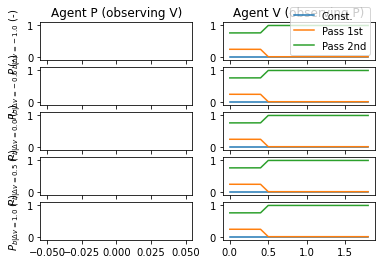

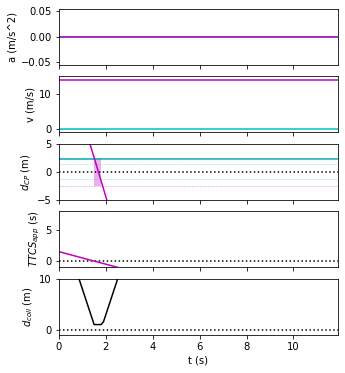

Metric VehPrioAssert_veh_av_speed = 13.88888888888889

	Scenario variation #2/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


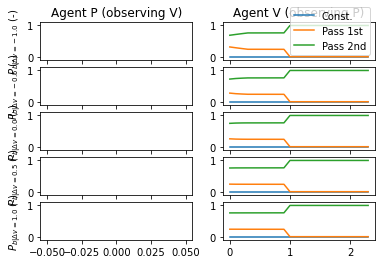

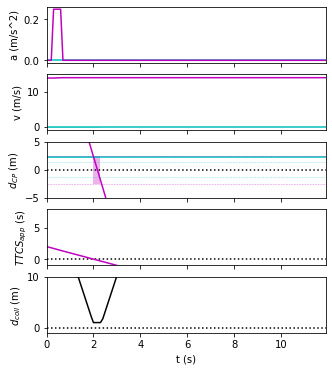

Metric VehPrioAssert_veh_av_speed = 13.933888888888891

	Scenario variation #3/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:

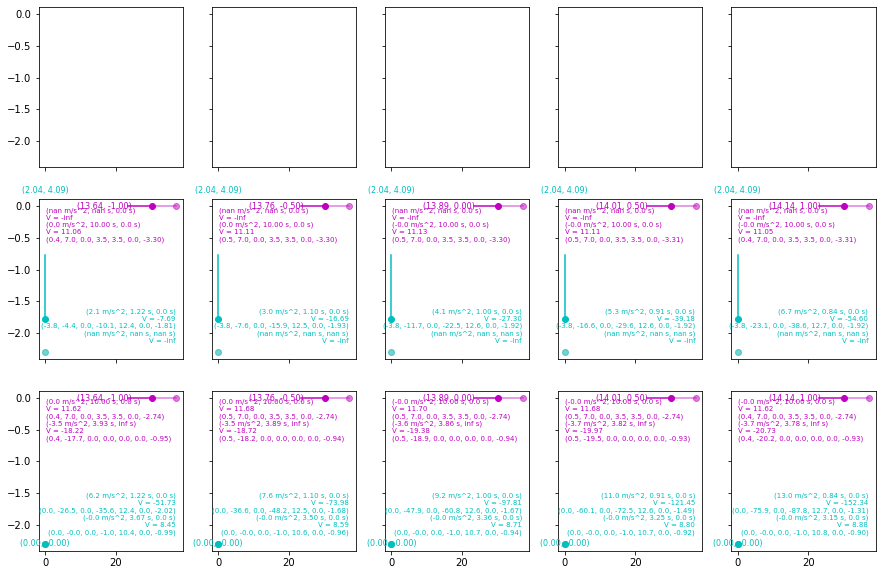

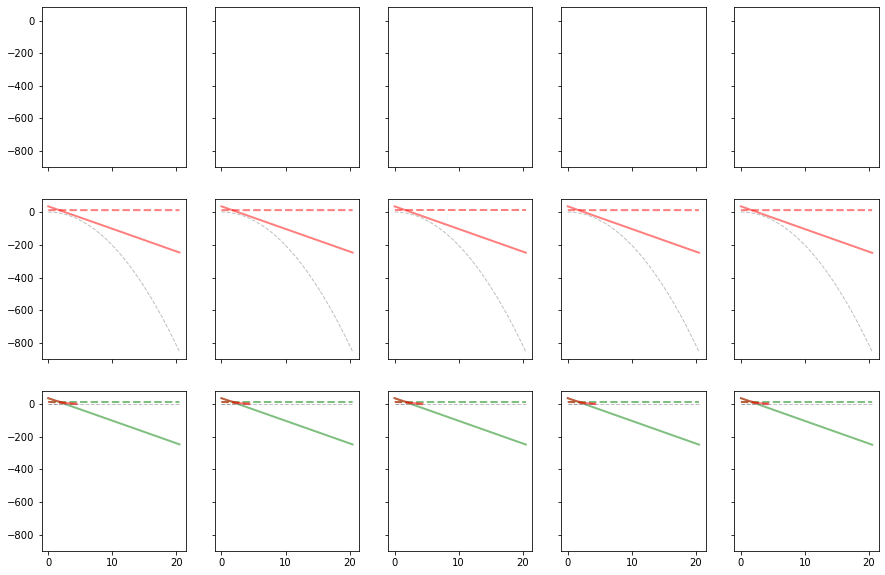

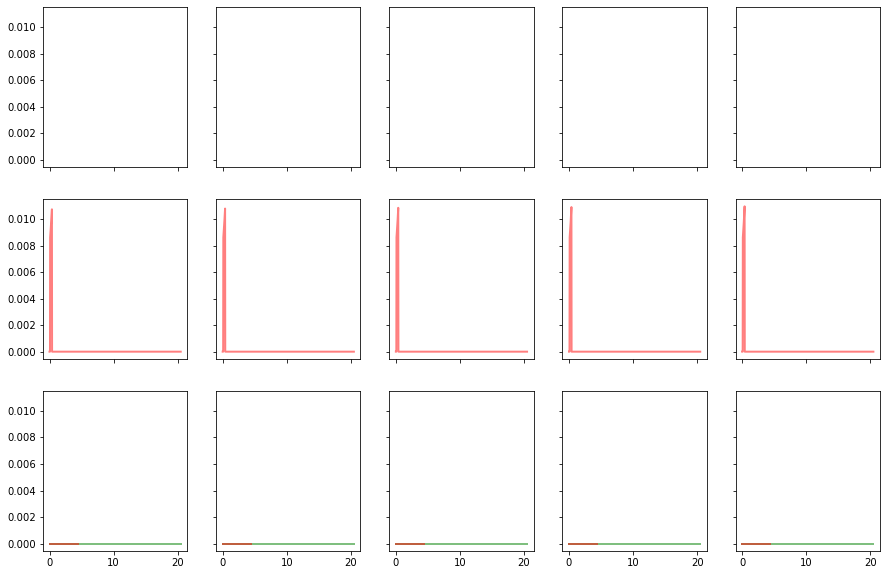

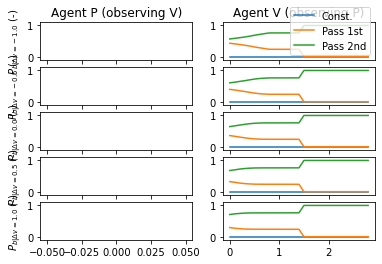

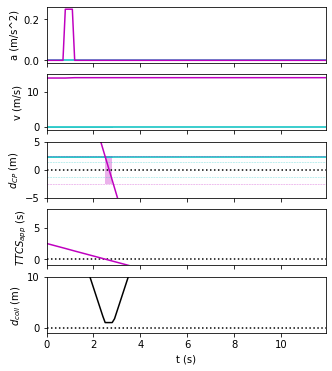

Metric VehPrioAssert_veh_av_speed = 13.90811965811966
Model parameterisation: {'T_delta': 10.0, 'thetaDot_1': 0.0015, 'beta_V': 1.0}

	Scenario variation #1/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


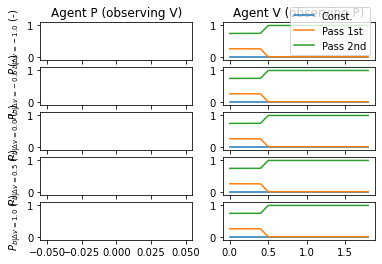

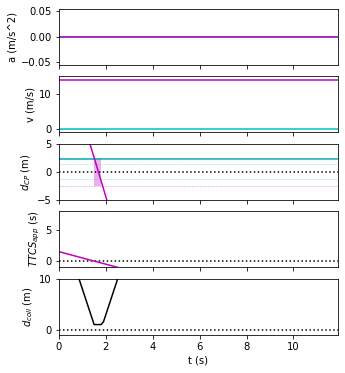

Metric VehPrioAssert_veh_av_speed = 13.88888888888889

	Scenario variation #2/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


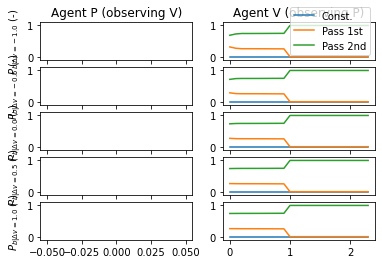

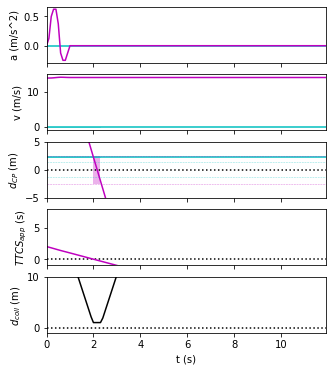

Metric VehPrioAssert_veh_av_speed = 14.006388888888889

	Scenario variation #3/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:

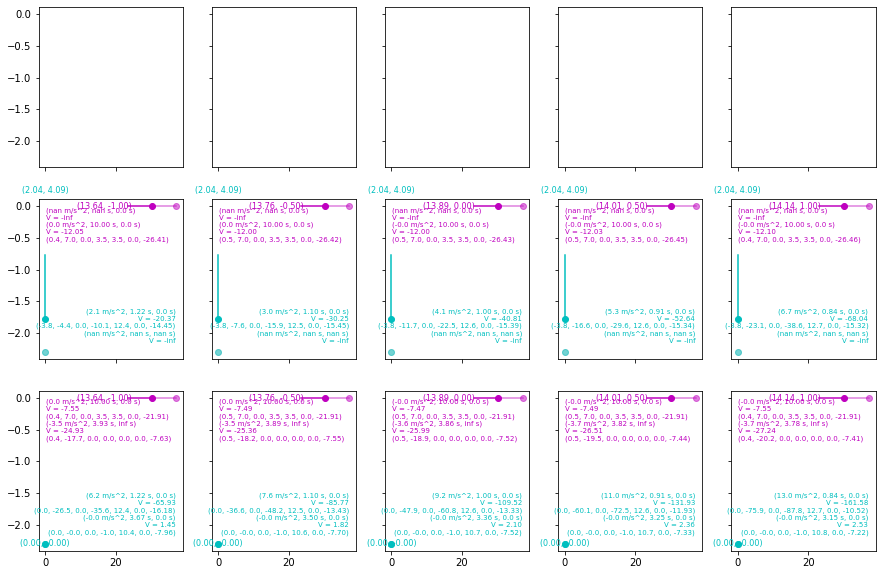

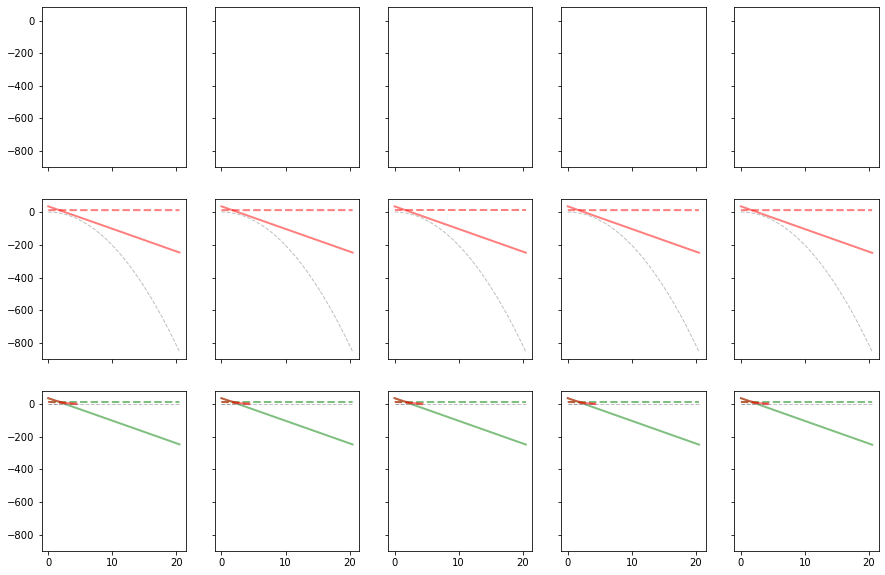

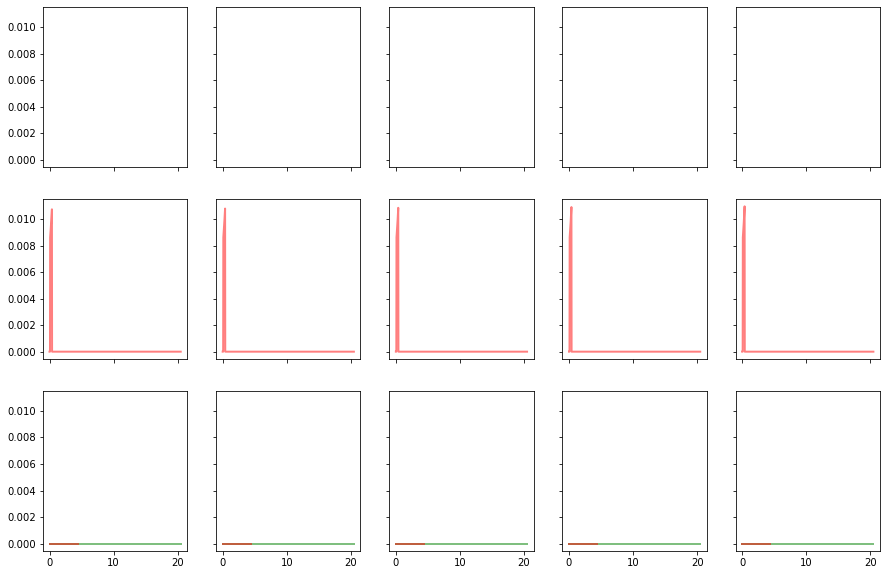

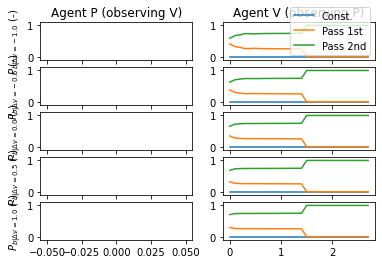

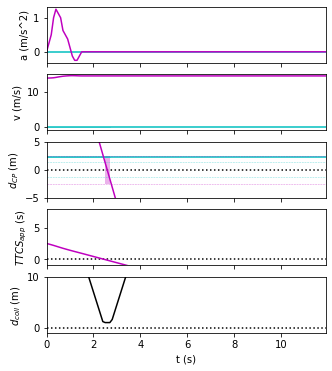

Metric VehPrioAssert_veh_av_speed = 14.250427350427351


In [21]:
model = 'oVAaoVAloBEvoAI'
scenario = sc_fitting.ONE_AG_SCENARIOS['VehPrioAssert']
for thetaDot_1 in (0.005, 0.0015):
    params_dict = {'T_delta': 10.0, 'thetaDot_1': thetaDot_1, 'beta_V': 1.0}
    print(f'Model parameterisation: {params_dict}')
    for i_variation in range(scenario.n_variations):
        print(f'\n\tScenario variation #{i_variation+1}/{scenario.n_variations}:')
        if i_variation == 2:
            snapshots = (None, (0,))
        else:
            snapshots = (None, None)
        run(i_variation=i_variation, snapshots=snapshots, detailed_snapshots=True)

### Summary

Here, the main action is to fix the bug in the looming value calculation mentioned above.

The only other action is probably to extend the search range for $\dot{\theta}_1$ downward, and possibly also to set $\dot{\theta}_0$ = 0.

However, if I make any changes discussed under "Short-stopping" above, I should also think carefully about, and test, whether that has any knock-on effects for the prio assertion scenario.

## Early pedestrian crossing

### Why does oVAoBE* not exhibit early pedestrian crossing?

As I thought, based on looking into this previously, the reason it doesn't is that when the car is close, crossing in front of it looks scary (requires a large passing-first acceleration) even when it is at a very slow speed, if one assumes that the car will remain at a constant speed, such as the `oVAoBE*` models do. So to capture this phenomenon (at least to capture it in the deterministic simulations) `oVAoBE*` simply won't do.


	Scenario variation #1/3:


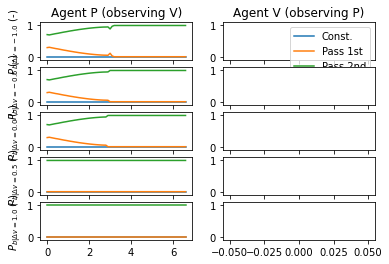

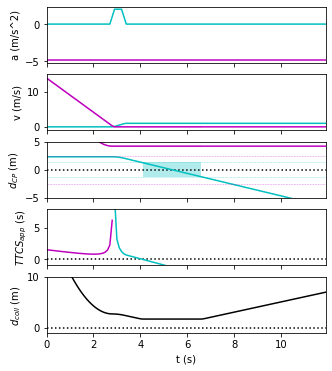

Metric PedCrossVehYield_veh_speed_at_ped_start = 0.0

	Scenario variation #2/3:


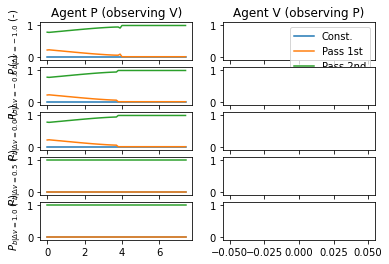

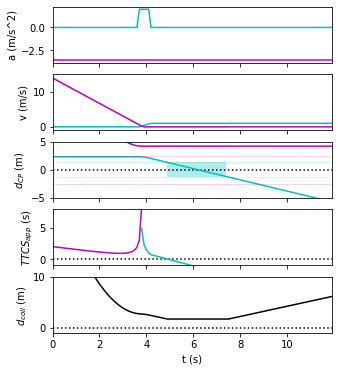

Metric PedCrossVehYield_veh_speed_at_ped_start = 0.0

	Scenario variation #3/3:


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:236: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


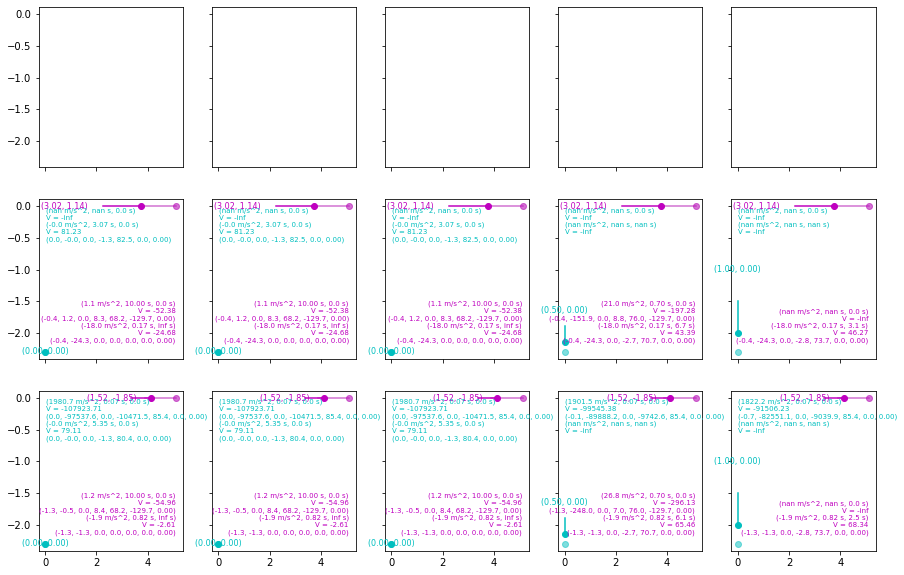

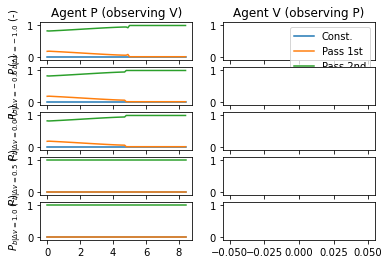

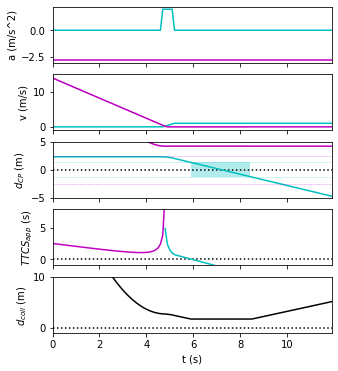

Metric PedCrossVehYield_veh_speed_at_ped_start = 0.0


In [25]:
model = 'oVAoBEvoAI'
params_dict = {'T_delta': 59.95, 'beta_V': 18.98}
scenario = sc_fitting.ONE_AG_SCENARIOS['PedCrossVehYield']
for i_variation in range(scenario.n_variations):
    print(f'\n\tScenario variation #{i_variation+1}/{scenario.n_variations}:')
    if i_variation == 2:
        snapshots = ((4,), None)
    else:
        snapshots = (None, None)
    run(i_variation=i_variation, snapshots=snapshots)

## Conclusions

Based on all of the above, I think the following actions would be appropriate next steps:
* Fix the bug in the looming value calculations, giving non-zero looming values also when $\dot{\theta} < \dot{\theta}_0$.
* Fix the awkward assumption combination for the `oVAaoBE*` models, I think preferably by considering ego-accelerations for acceleration-controlling but not speed-controlling ego agents, when generating other-behaviour hypotheses in these models.
* Possibly: Update the numerical looming integration to also include movement after regaining free speed, if still not fully clear of the conflict space.
* Extend the search range for $\dot{\theta}_1$ downward, and probably also set $\dot{\theta}_0$ = 0.